# Code for plotting the average diurnal variation of the absolute error for each season 

#### Remove divide_months and divide_hours when included in METCOMP_utils.py?

In [12]:
import pandas as pd
def divide_months(df):
    months = {}
    for month in range(1, 13):
        
        # Get hour string as two character string.
        month_str = ''
        if month < 10:
            month_str = '0' + str(month)
        else:
            month_str = str(month)
        months[month] = df[df['Timestamp'].str.contains('-' + month_str + '-')]
        
    return months

In [13]:
import pandas as pd
def divide_hours(df):
    
    hours = {}
    
    for hour in range(0, 24):
        
        # Get hour string as two character string.
        hour_str = ''
        if hour < 10:
            hour_str = '0' + str(hour)
        else:
            hour_str = str(hour)
        hours[hour] = df[df['Timestamp'].str.contains('T' + hour_str)]
        
    return hours

Loading data...
Finding rows where both datasets has zero precipitation...
Dropping rows where both datasets has zero precipitation...
Preprocessing...
Plotting...


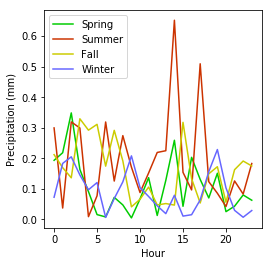

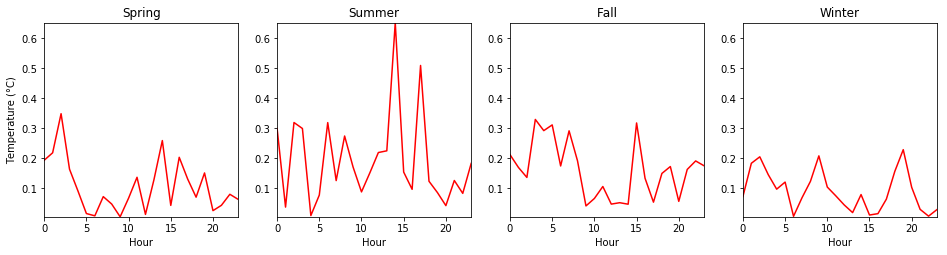

In [14]:
import pandas as pd
import numpy as np
import datetime
from METCOMP_utils import *
import matplotlib.pyplot as plt

# Choose parameter to analyse
param = 'RR'

param_dict = {'TM': 't_sfc', 'RR': 'prec1h_sfc', 'UM': 'r_sfc', 'FM2': 'ws_sfc'}

# Load data.
print('Loading data...')
start_date = datetime.date(2017, 3, 1)
end_date = datetime.date(2020, 2, 29)
df_MESAN = read_CSV('40010', 'MESAN', start_date, end_date)
df_LANTMET = get_LANTMET('40010', start_date, end_date)

# Unit conversion if needed.
if param == 'TM':
    df_MESAN[param_dict[param]] = df_MESAN[param_dict[param]] - 273.15
elif param == 'UM':
    df_MESAN[param_dict[param]] = df_MESAN[param_dict[param]]*100

# Calculate wind speed
if param == 'FM2':
    print('Getting wind speed...')
    MESAN_ws = np.sqrt(np.square(df_MESAN['u_sfc']) + np.square(df_MESAN['v_sfc']))
    df_MESAN['ws_sfc'] = MESAN_ws
    
# Remove rows where both datasets has zero precipitation
if param == 'RR':
    # Reset index
    df_MESAN.reset_index(inplace=True)
    df_LANTMET.reset_index(inplace=True)
    print('Finding rows where both datasets has zero precipitation...')
    zero_rows = []
    for index, row in df_MESAN.iterrows():
        if df_MESAN.iloc[index]['prec1h_sfc'] == 0 and df_LANTMET.iloc[index]['RR'] == 0:
            zero_rows.append(index)
    print('Dropping rows where both datasets has zero precipitation...')
    df_MESAN = df_MESAN.drop(df_MESAN.index[zero_rows]);
    df_LANTMET = df_LANTMET.drop(df_LANTMET.index[zero_rows]);

print('Preprocessing...')
MESAN_months = divide_months(df_MESAN)
LANTMET_months = divide_months(df_LANTMET)

seasons = {'spring': [3, 4, 5], 'summer': [6, 7, 8], 'fall': [9, 10, 11], 'winter': [12, 1, 2]}

MESAN_seasons_data = {'spring': None, 'summer': None, 'fall': None, 'winter': None}
LANTMET_seasons_data = {'spring': None, 'summer': None, 'fall': None, 'winter': None}

# Divide dataset into seasons.
for season in seasons:
    for month in seasons[season]:
        MESAN_seasons_data[season] = pd.concat([MESAN_seasons_data[season], MESAN_months[month]], axis=0, ignore_index=True)
        LANTMET_seasons_data[season] = pd.concat([LANTMET_seasons_data[season], LANTMET_months[month]], axis=0, ignore_index=True)

for season in seasons:
    MESAN_seasons_data[season] = divide_hours(MESAN_seasons_data[season])
    LANTMET_seasons_data[season] = divide_hours(LANTMET_seasons_data[season])

    
ERROR_seasons_data = {'spring': None, 'summer': None, 'fall': None, 'winter': None}
for season in seasons:
    tmp_MESAN = []
    tmp_LANTMET = []
    tmp_ERROR = []
    for hour in range(0, 24):
        #tmp_MESAN.append(MESAN_seasons_data[season][hour][param_dict[param]].mean(skipna=True) - 273.15)
        tmp_MESAN.append(MESAN_seasons_data[season][hour][param_dict[param]].mean(skipna=True))
        tmp_LANTMET.append(LANTMET_seasons_data[season][hour][param].mean(skipna=True))
        tmp_ERROR.append(abs(tmp_MESAN[hour] - tmp_LANTMET[hour]))
    MESAN_seasons_data[season] = tmp_MESAN
    LANTMET_seasons_data[season] = tmp_LANTMET
    ERROR_seasons_data[season] = tmp_ERROR


print('Plotting...')

fig, ax = plt.subplots(figsize=(4, 4))
hours = [i for i in range(0, 24)]
ax.plot(hours, ERROR_seasons_data['spring'], color=[0.0, 0.8, 0.0], label='Spring')
ax.plot(hours, ERROR_seasons_data['summer'], color=[0.8, 0.2, 0.0], label='Summer')
ax.plot(hours, ERROR_seasons_data['fall'], color=[0.8, 0.8, 0.0], label='Fall')
ax.plot(hours, ERROR_seasons_data['winter'], color=[0.4, 0.4, 1.0], label='Winter')
ax.legend()
ax.set_xlabel('Hour')
if param == 'TM':
    ax.set_ylabel('Temperature (°C)')
if param == 'UM':
    ax.set_ylabel('Relative humidity (%)')
if param == 'RR':
    ax.set_ylabel('Precipitation (mm)')
if param == 'FM2':
    ax.set_ylabel('Wind speed (m/s)')
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))

# Saving the resulting figure in .pdf format
if param == 'TM':
    plt.savefig('TM_season_daily_variation.pdf')
if param == 'UM':
    plt.savefig('UM_season_daily_variation.pdf')
if param == 'RR':
    fig.savefig('RR_season_daily_variation.pdf')
if param == 'FM2':
    plt.savefig('FM2_season_daily_variation.pdf')
    
# Errors.
ylims = [max(ERROR_seasons_data['spring']),
         max(ERROR_seasons_data['summer']),
         max(ERROR_seasons_data['fall']),
         max(ERROR_seasons_data['winter']),
         min(ERROR_seasons_data['spring']),
         min(ERROR_seasons_data['summer']),
         min(ERROR_seasons_data['fall']),
         min(ERROR_seasons_data['winter'])]
ylims = [min(ylims), max(ylims)]
fig, axs = plt.subplots(1, 4, figsize=(16, 16))
hours = [i for i in range(0, 24)]
axs[0].plot(hours, ERROR_seasons_data['spring'], color=[1.0, 0.0, 0.0], label='Spring')
axs[0].set_xlim([0, 23])
axs[0].set_ylim(ylims)
axs[0].set_xlabel('Hour')
axs[0].set_ylabel('Temperature (°C)')
axs[0].set_title('Spring')
x0,x1 = axs[0].get_xlim()
y0,y1 = axs[0].get_ylim()
axs[0].set_aspect(abs(x1-x0)/abs(y1-y0))
    

axs[1].plot(hours, ERROR_seasons_data['summer'], color=[1.0, 0.0, 0.0], label='Summer')
axs[1].set_xlim([0, 23])
axs[1].set_ylim(ylims)
axs[1].set_xlabel('Hour')
axs[1].set_title('Summer')
x0,x1 = axs[1].get_xlim()
y0,y1 = axs[1].get_ylim()
axs[1].set_aspect(abs(x1-x0)/abs(y1-y0))
    

axs[2].plot(hours, ERROR_seasons_data['fall'], color=[1.0, 0.0, 0.0], label='Fall')
axs[2].set_xlim([0, 23])
axs[2].set_ylim(ylims)
axs[2].set_xlabel('Hour')
axs[2].set_title('Fall')
x0,x1 = axs[2].get_xlim()
y0,y1 = axs[2].get_ylim()
axs[2].set_aspect(abs(x1-x0)/abs(y1-y0))
    

axs[3].plot(hours, ERROR_seasons_data['winter'], color=[1.0, 0.0, 0.0], label='Winter')
axs[3].set_xlim([0, 23])
axs[3].set_ylim(ylims)
axs[3].set_xlabel('Hour')
axs[3].set_title('Winter')
x0,x1 = axs[3].get_xlim()
y0,y1 = axs[3].get_ylim()
axs[3].set_aspect(abs(x1-x0)/abs(y1-y0))